# Natural Language Detector

Dense neural network for language detection. Model is capable of predicting one of 17 learned languages for a given sentence. Dataset consists of over 10k labeled sentences. Each sentence was vectorized using trigram technique and fed to neural net. Accuracy of the model is over 96% on test dataset.

In [1]:
import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# read dataframe
df = pd.read_csv('Language Detection.csv', sep=',', encoding='utf-8')
df.sample(5)

,Text,Language
3976,"c'est la meilleure vidéo pour commencer, alors...",French
674,"[302] During the COVID-19 pandemic, Wikipedia'...",English
8624,väldigt suave så smart ord nummer fyra är grym...,Sweedish
1732,വിരലുകൾ മറികടന്നു.,Malayalam
5373,"y no entendiste lo que decía la otra persona, ...",Spanish


In [3]:
# remove digits
df['Text'] = df['Text'].str.replace('[0-9]','')

# strip punctuation
df['Text'] = df['Text'].str.replace('[^\w\s]','')

# remove extra spaces
df['Text'] = df['Text'].str.strip()

# to lower
df['Text'] = df['Text'].str.lower()

In [4]:
# get labels
names = df['Language'].unique()

# count sentences for each label
counts = df['Language'].value_counts().to_numpy()

In [5]:
# create list with legths of sentences
seq_lens = df['Text'].apply(lambda x: len(x.split())).to_numpy()

# calculate max saequence length
max_len = int(np.mean(seq_lens) + 2*np.std(seq_lens))

# cut Texts to max len
df['Text'] = df['Text'].apply(lambda x: ' '.join(x.split()[:max_len]))

In [6]:
# print some basic statistics
print('max seqience length:\t\t', max_len)
print('no. of sequences untruncated:\t', np.sum(seq_lens < max_len))
print('no. of sequences truncated:\t', np.sum(seq_lens >= max_len))

max seqience length:		 111
no. of sequences untruncated:	 10304
no. of sequences truncated:	 33


In [7]:
# add new column with length of sentence
df['Length'] = df['Text'].apply(lambda x: len(x.split(' '))).to_numpy()
df.sample(5)

,Text,Language,Length
3446,wikipédia écouter est une encyclopédie univers...,French,17
7971,testte tek bir soruyu cevaplamak için ya da cö...,Turkish,33
9352,اعتن بنفسك,Arabic,2
135,the human ecosystem concept is based on the hu...,English,32
6130,открытый характер модели редактирования являет...,Russian,11


In [8]:
def show_values_on_bars(axs, h_v='v', space=0.4, height=0):
    '''
    function used to show values on top of bars
    
    axs:    axis to draw values on
    h_v:    whether bars on plots are vertical or horizontal
    space:  space between value on top of bar (only in vertical plot)
    height: space between value on top of bar (only in horizontal plot)
    '''
    
    def _show_on_single_plot(ax):
        
        # vertical axis
        if h_v == 'v':
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + height
                value = int(p.get_height())
                ax.text(_x, _y, value, ha='center') 
                
        # horizontal axis
        elif h_v == 'h':
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() / 4
                value = int(p.get_width())
                ax.text(_x, _y, value, ha='left')
                
    # multiple plots
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    
    # single plot
    else:
        _show_on_single_plot(axs)

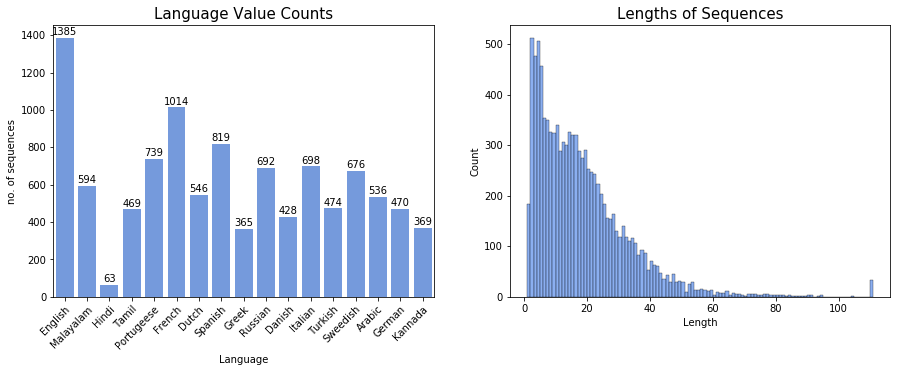

In [9]:
# visualize how many sequences belong to each class
# and length of sentences
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(x='Language', data=df, color='cornflowerblue', ax=ax1)
ax1.set_title('Language Value Counts', size=15)
ax1.set_xticklabels(names, rotation=45, rotation_mode="anchor", ha="right")
ax1.set_ylabel('no. of sequences')
show_values_on_bars(ax1, height=15)

sns.histplot(df['Length'], binwidth=1, color='cornflowerblue')
ax2.set_title('Lengths of Sequences', size=15)
ax2.set_xlabel('Length')

plt.show()

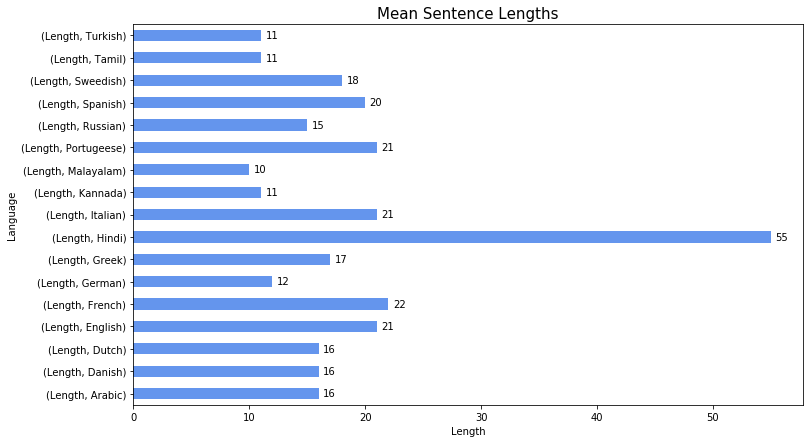

In [10]:
# show mean sentence length based on language 
plt.figure(figsize=(12, 7))
plot = df.groupby('Language').agg('mean').astype('int').unstack().plot.barh(color='cornflowerblue')
plt.title('Mean Sentence Lengths', size=15)
plt.xlabel('Length')
plt.ylabel('Language')
show_values_on_bars(plot, h_v='h')
plt.show()

In [11]:
# divide into input and output
X, y = df['Text'], df['Language']

In [12]:
# create and fit encoder on labels
encoder = LabelEncoder()
encoder.fit(names)
encoder.classes_

array(['Arabic', 'Danish', 'Dutch', 'English', 'French', 'German',
       'Greek', 'Hindi', 'Italian', 'Kannada', 'Malayalam', 'Portugeese',
       'Russian', 'Spanish', 'Sweedish', 'Tamil', 'Turkish'], dtype=object)

In [13]:
def generate_trigrams(df, names, num_features=200):
    '''
    function used to generate trigrams of length 3 from given dataset
    from each language only n most common trigrams are extracted
    
    df:           input dataframe
    names:        labels
    num_features: how many trigrams to extract
    '''
    
    # combined trigrams from all classes
    trigrams = []
    
    # instantiate vectorizer
    vectorizer = CountVectorizer(ngram_range=(3,3),
                                analyzer='char',
                                dtype='int32',
                                max_features=num_features)
    
    # loop over labels
    for name in names:
        
        # select all sentences from one language
        rows = df[df['Language'] == name]['Text']
        
        # fit vectorizer with sentences
        vectorizer.fit(rows)
        
        # get extracted trigrams
        grams = vectorizer.get_feature_names()
        
        # append to returned array
        trigrams += grams
        
    return trigrams

In [14]:
# generate trigrams from train set
trigrams = generate_trigrams(df, names)

In [15]:
# vectorizer containing all trigrams
vectorizer = CountVectorizer(ngram_range=(3,3),
                             analyzer='char',
                             dtype='int32')

In [16]:
# fit on created trigrams
vectorizer.fit(trigrams)

# vectorize train set
X = vectorizer.transform(X)

In [17]:
# example trigrams
vectorizer.get_feature_names()[:10]

[' a ', ' aa', ' af', ' al', ' an', ' ar', ' as', ' at', ' au', ' av']

In [18]:
# scaler used for better results
scaler = MinMaxScaler()

# scale values to [0, 1]
X_scaled = scaler.fit_transform(X.toarray())

In [19]:
# create dataframe with vectorized train set
x_df = pd.DataFrame(X_scaled, columns=vectorizer.get_feature_names())

# labels
y_encoded = encoder.transform(y)

x_df.to_numpy().shape, y_encoded.shape

((10337, 2356), (10337,))

In [20]:
# split into train, val, test datasets
# stratify is used when dataset is imbalanced

x_train, x_test, y_train, y_test = train_test_split(x_df, 
                                                    y_encoded, 
                                                    train_size=0.85, 
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=2018)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  train_size=0.85, 
                                                  shuffle=True, 
                                                  stratify=y_train, 
                                                  random_state=2018)

# print sizes of sets
len(x_train), len(x_val), len(x_test)

(7468, 1318, 1551)

In [23]:
def create_model(units=16, 
                 dropout=0.3, 
                 activation='relu', 
                 optimizer='adam', 
                 regularization=None):
    
    model = keras.Sequential(
        [
            layers.Input(shape=(x_df.shape[1], )),
            
            layers.Dense(units=units, 
                         activation=activation, 
                         kernel_regularizer=regularization),
            
            layers.Dropout(dropout),
            
            layers.Dense(units=units, 
                         activation=activation, 
                         kernel_regularizer=regularization),
            
            layers.Dropout(dropout),
            
            layers.Dense(len(names), activation='softmax')
            
        ], name='Sequential_model_vol_1'
    )

    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=[
                      metrics.SparseCategoricalAccuracy(name='accuracy'), 
                      metrics.SparseTopKCategoricalAccuracy(k=3, name='top-3-accuracy')
                  ]
    )
    return model

In [24]:
params = {
    'units': 8,
    'dropout': 0.2,
    'activation': 'relu',
    'optimizer': optimizers.Adam(),
}

In [24]:
build_fn must be callable so lambda is necessary
wrapped_model = KerasClassifier(build_fn=lambda : create_model(**params), 
                                epochs=20, 
                                batch_size=128, 
                                shuffle=True,
                                verbose=0)

In [25]:
# calculate score from cross validation
model_score = cross_val_score(wrapped_model, 
                              x_train, 
                              y_train, 
                              cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=2018), 
                              scoring="accuracy", 
)

In [26]:
print('Mean Stratified 10-Fold Cross Validation: ', round(model_score.mean(), 4))

Mean Stratified 10-Fold Cross Validation:  0.9175


### Small Randomized Grid Search

In [39]:
# dummy parameter space
param_grid = {
    'units': [32, 64, 128],
    'dropout': [0.2, 0.3, 0.5],
    'activation': ['relu', 'sigmoid'],
    'optimizer': [optimizers.Adam(), optimizers.SGD(), optimizers.RMSprop()],
    'regularization': [None, regularizers.l2(), regularizers.l1(), regularizers.l1_l2()],
}

In [40]:
w_model = KerasClassifier(create_model)

In [41]:
cv_clf = RandomizedSearchCV(
    estimator=KerasClassifier(create_model),
    param_distributions=param_grid, 
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    cv=10
)

In [1]:
# sometimes does not work :v 
# cv_clf.fit(x_train, y_train, verbose=0)

In [43]:
cv_clf.best_params_

{'units': 64,
 'regularization': None,
 'optimizer': <keras.optimizer_v2.adam.Adam at 0x1dad028a6d8>,
 'dropout': 0.5,
 'activation': 'relu'}

In [66]:
# best parameters 
best_params = {
    'units': 64,
    'regularization': None,
    'optimizer': optimizers.Adam(),
    'dropout': 0.5,
    'activation': 'relu', 
}

In [67]:
model = create_model(**best_params)
model.summary()

Model: "Sequential_model_vol_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 64)                150848    
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_33 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 17)                1105      
Total params: 156,113
Trainable params: 156,113
Non-trainable params: 0
_________________________________________________________________


### Training & Results

In [68]:
# reduce learning rate 
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5
)

# stop if overfitting
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

In [69]:
# training
his = model.fit(x_train, 
                y_train, 
                epochs=50, 
                batch_size=128, 
                shuffle=True, 
                validation_data=(x_val, y_val), 
                callbacks=[reduce_lr, early_stopping], 
                verbose=0)

In [42]:
model.save('model_64.h5')

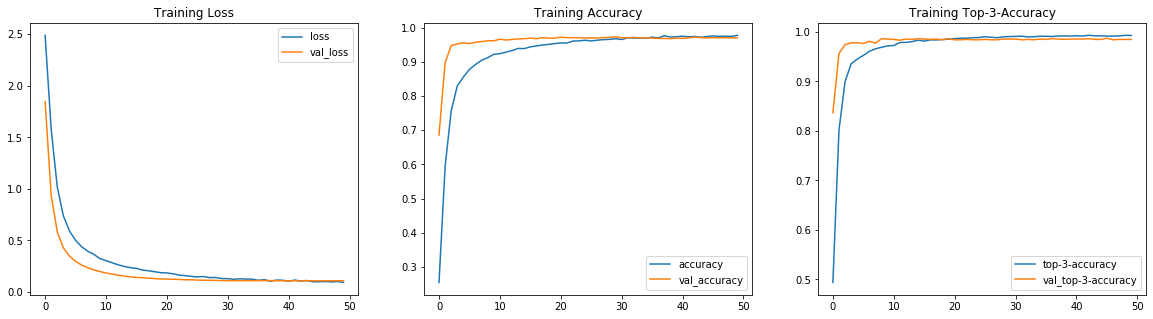

In [70]:
# plot training results
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].plot(his.history['loss'], label='loss')
axs[0].plot(his.history['val_loss'], label='val_loss')
axs[0].set_title('Training Loss')
axs[0].legend()

axs[1].plot(his.history['accuracy'], label='accuracy')
axs[1].plot(his.history['val_accuracy'], label='val_accuracy')
axs[1].set_title('Training Accuracy')
axs[1].legend()

axs[2].plot(his.history['top-3-accuracy'], label='top-3-accuracy')
axs[2].plot(his.history['val_top-3-accuracy'], label='val_top-3-accuracy')
axs[2].set_title('Training Top-3-Accuracy')
axs[2].legend()

plt.show()

In [71]:
_, acc, top3acc = model.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy:\t\t', round(acc, 3))
print('Test Top-3-Accuracy:\t', round(top3acc, 3))

Test Accuracy:		 0.967
Test Top-3-Accuracy:	 0.989


In [73]:
# create confusion matrix
logits = model.predict(x_test)
argmax = np.argmax(logits, axis=1)

y_pred = encoder.inverse_transform(argmax)
y_actual = encoder.inverse_transform(y_test)
matrix = confusion_matrix(y_actual, y_pred)

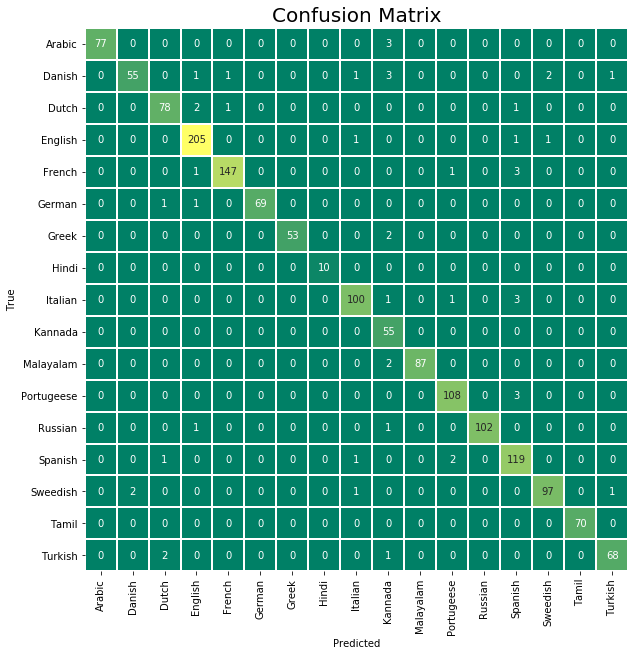

In [74]:
# plot confusion matrix
plt.figure(figsize=(10, 10))
plt.title('Confusion Matrix', size=20)
ax = sns.heatmap(matrix, square=True, xticklabels=encoder.classes_, yticklabels=encoder.classes_, 
            cmap="summer", annot=True, linewidths=1, fmt='g', cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5);

In [75]:
# print some other statistics
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

      Arabic       1.00      0.96      0.98        80
      Danish       0.96      0.86      0.91        64
       Dutch       0.95      0.95      0.95        82
     English       0.97      0.99      0.98       208
      French       0.99      0.97      0.98       152
      German       1.00      0.97      0.99        71
       Greek       1.00      0.96      0.98        55
       Hindi       1.00      1.00      1.00        10
     Italian       0.96      0.95      0.96       105
     Kannada       0.81      1.00      0.89        55
   Malayalam       1.00      0.98      0.99        89
  Portugeese       0.96      0.97      0.97       111
     Russian       1.00      0.98      0.99       104
     Spanish       0.92      0.97      0.94       123
    Sweedish       0.97      0.96      0.97       101
       Tamil       1.00      1.00      1.00        70
     Turkish       0.97      0.96      0.96        71

    accuracy              

In [41]:
from tensorflow.keras.models import load_model
model = load_model('model_64.h5')

In [120]:
# requires: Model, Vectorizer, LabelEncoder, MinMaxScaler
def classify_sentence(sentence, language=None):
    from termcolor import colored
    import re
    
    # preprocessing
    sent = re.sub(r'[0-9]', '', sentence)
    sent = re.sub(r'[^\w\s]', '', sent)
    sent = re.sub(r' +', ' ', sent)
    sent = sent.strip().lower()
    
    # prediction
    x = vectorizer.transform([sent])
    x = scaler.transform(x.toarray())
    logits = model.predict(x)
    argmax = np.argmax(logits)
    label = encoder.inverse_transform([argmax])[0]
    
    # printing
    if language is not None:
        color = 'green' if label == language else 'red'
    else: color = 'grey'
    print('Sentence:\t', sentence)
    print('Predicted:\t', colored(label, color))
    if language is not None:
        print('Actual:\t\t', colored(language, color))

In [115]:
classify_sentence('J\'espère que ce traducteur sait quelque chose', 'French')

Sentence:	 J'espère que ce traducteur sait quelque chose
Predicted:	 French
Actual:		 French


In [116]:
classify_sentence('Adios caballeros', 'Spanish')

Sentence:	 Adios caballeros
Predicted:	 Spanish
Actual:		 Spanish


In [117]:
classify_sentence('короткое предложение', 'Russian')

Sentence:	 короткое предложение
Predicted:	 Russian
Actual:		 Russian


In [118]:
classify_sentence('ಇದು ಒಳ್ಳೆಯದಲ್ಲ ಬಾಬ್, ಇದು ಒಳ್ಳೆಯದಲ್ಲ', 'Kannada')

Sentence:	 ಇದು ಒಳ್ಳೆಯದಲ್ಲ ಬಾಬ್, ಇದು ಒಳ್ಳೆಯದಲ್ಲ
Predicted:	 Kannada
Actual:		 Kannada


In [123]:
classify_sentence('är det ens vettigt?', 'Sweedish')

Sentence:	 är det ens vettigt?
Predicted:	 Sweedish
Actual:		 Sweedish


In [119]:
classify_sentence('मैं दोपहर से पहले वापस आ जाऊंगाಲ', 'Hindi')

Sentence:	 मैं दोपहर से पहले वापस आ जाऊंगाಲ
Predicted:	 Arabic
Actual:		 Hindi


In [108]:
classify_sentence('я люблю блины.', 'Russian')

Sentence:	 я люблю блины
Predicted:	 Kannada
Actual:		 Russian


In [105]:
classify_sentence('Boa noite!', 'Portugeese')

Sentence:	 Boa noite!
Predicted:	 Spanish
Actual:		 Portugeese


In [113]:
classify_sentence('I do!', 'English')

Sentence:	 I do
Predicted:	 Italian
Actual:		 English


In [114]:
classify_sentence('Qwerryty gfdihdsf vbvcbv?')

Sentence:	 qwerryty gfdihdsf vbvcbv
Predicted:	 German
